In [38]:
# Allows to make changes to the classes without restarting the notebook 💀 # TODO: Delete once done
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate

In [40]:
from continuous_model.Bee import BeeSwarm
from continuous_model.Hive import Hive
from continuous_model.Model import ForagerModel
from continuous_model.Resource import Resource
from continuous_model.config import *

In [41]:
# Workaround for TQDM's nested loops
from IPython.core.display import HTML

display(HTML("""
    <style>
        .jp-OutputArea-child:has(.jp-OutputArea-prompt:empty) {
              padding: 0 !important;
        }
    </style>
"""))

In [42]:
DATA_PATH = "./data/"
FIGURE_PATH = "./fig/"

## Colony survival after one day

* 1 day experiment
* Initial hive storage: 25%

In [43]:
STORM_PROBABILITIES = np.linspace(0.0, 0.2, 11)
RESOURCE_DISTANCES = np.linspace(50.0, 1050.0, 11)

INITIAL_COLONY_SIZE = 100
TIMESTEPS = 2880
N_RUNS = 10

save_data = True   # TODO: Set to False

In [44]:
COLONY_SURVIVAL = np.zeros((N_RUNS, len(STORM_PROBABILITIES), len(RESOURCE_DISTANCES)))
NECTAR_CHANGE = np.zeros((N_RUNS, len(STORM_PROBABILITIES), len(RESOURCE_DISTANCES)))

In [45]:
hive_config = HiveConfig()
beeswarm_config = BeeSwarmConfig()
resource_config = ResourceConfig()

In [46]:
for (i, p_storm) in tqdm(enumerate(STORM_PROBABILITIES), total=len(STORM_PROBABILITIES), leave=True):
    for (j, res_dist) in tqdm(enumerate(RESOURCE_DISTANCES), total=len(RESOURCE_DISTANCES), leave=False):
        for k in range(N_RUNS):
            model_config = ModelConfig(n_resource_sites=0, p_storm=p_storm, n_beeswarms_initial=INITIAL_COLONY_SIZE)
            model = ForagerModel(model_config, hive_config, beeswarm_config, resource_config)

            hive = model.get_agents_of_type(Hive)[0]

            model.create_agent(Resource, location=(hive.pos[0] - res_dist, hive.pos[1]))
            # model.create_agent(Resource, location=(hive.pos[0] + res_dist, hive.pos[1]))
            # model.create_agent(Resource, location=(hive.pos[0], hive.pos[1] - res_dist))
            # model.create_agent(Resource, location=(hive.pos[0], hive.pos[1] + res_dist))

            for _ in range(TIMESTEPS):
                model.step()
            
            n_bee_agents = len(model.get_agents_of_type(BeeSwarm))
            fraction_colony_survived = n_bee_agents / INITIAL_COLONY_SIZE

            hive = model.get_agents_of_type(Hive)[0]
            final_nectar = hive.nectar / hive_config.default_nectar

            COLONY_SURVIVAL[k, i, j] = fraction_colony_survived
            NECTAR_CHANGE[k, i, j] = final_nectar

        if save_data:
            np.save(DATA_PATH + "colony_survival.npy", COLONY_SURVIVAL)
            np.save(DATA_PATH + "nectar_change.npy", NECTAR_CHANGE)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
nectar_mean = np.mean(NECTAR_CHANGE, axis=0)
nectar_sd = np.std(NECTAR_CHANGE, axis=0)

colony_mean = np.mean(COLONY_SURVIVAL, axis=0)
colony_sd = np.std(COLONY_SURVIVAL, axis=0)

In [ ]:
X, Y = np.meshgrid(STORM_PROBABILITIES, RESOURCE_DISTANCES)

## Raw data plot

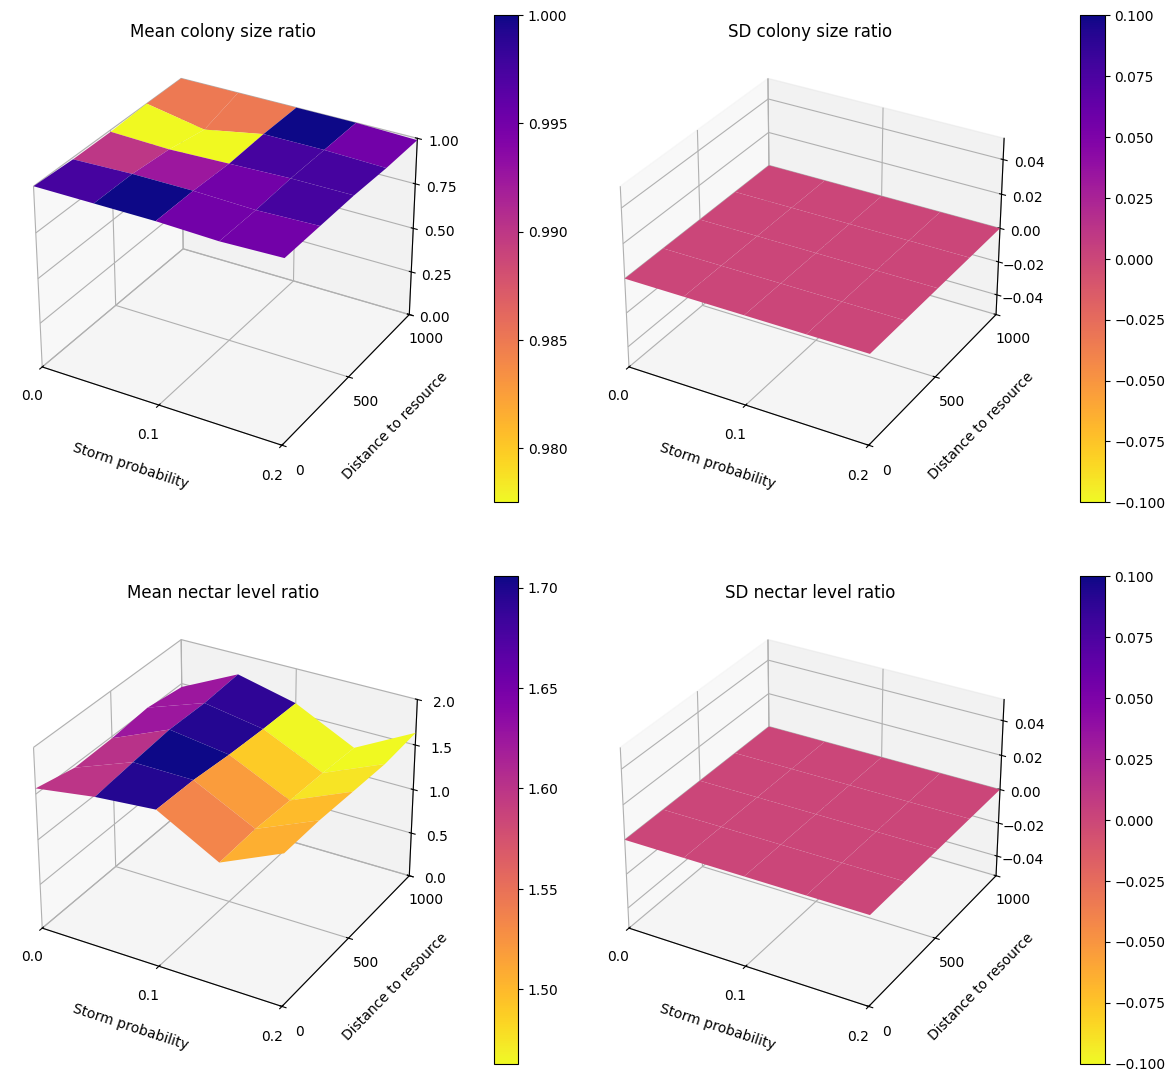

In [ ]:
fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 12))
plot_data = [colony_mean, colony_sd, nectar_mean, nectar_sd]

for (data, ax) in zip(plot_data, axes.flatten()):
    surf = ax.plot_surface(X, Y, data, cmap=plt.cm.summer, alpha=None, antialiased=True)
    ax.plot_wireframe(X, Y, data, lw=0.5, color='black', alpha=None, antialiased=True)

    ax.set_xlabel("Storm probability", labelpad=10.0)
    ax.set_xlim(0, 0.2)
    ax.set_xticks(np.linspace(0, 0.2, 3))

    ax.set_ylabel("Distance to resource", labelpad=10.0)
    ax.set_ylim(0, 1000)
    ax.set_yticks(np.linspace(0, 1000, 3))

    fig.colorbar(surf, ax=ax, shrink=0.8, aspect=20, pad=0.1)

axes[0,0].set_title("Mean colony size ratio")
axes[0,0].set_zlim(0, 1)
axes[0,0].set_zticks(np.linspace(0, 1.0, 5))

axes[0,1].set_title("SD colony size ratio")

axes[1,0].set_title("Mean nectar level ratio")
axes[1,0].set_zlim(0, 2)
axes[1,0].set_zticks(np.linspace(0, 2.0, 5))

axes[1,1].set_title("SD nectar level ratio")

plt.tight_layout()
plt.savefig(FIGURE_PATH + "colony_survival_and_nectar_levels.png", bbox_inches='tight')

## Smooth data plot

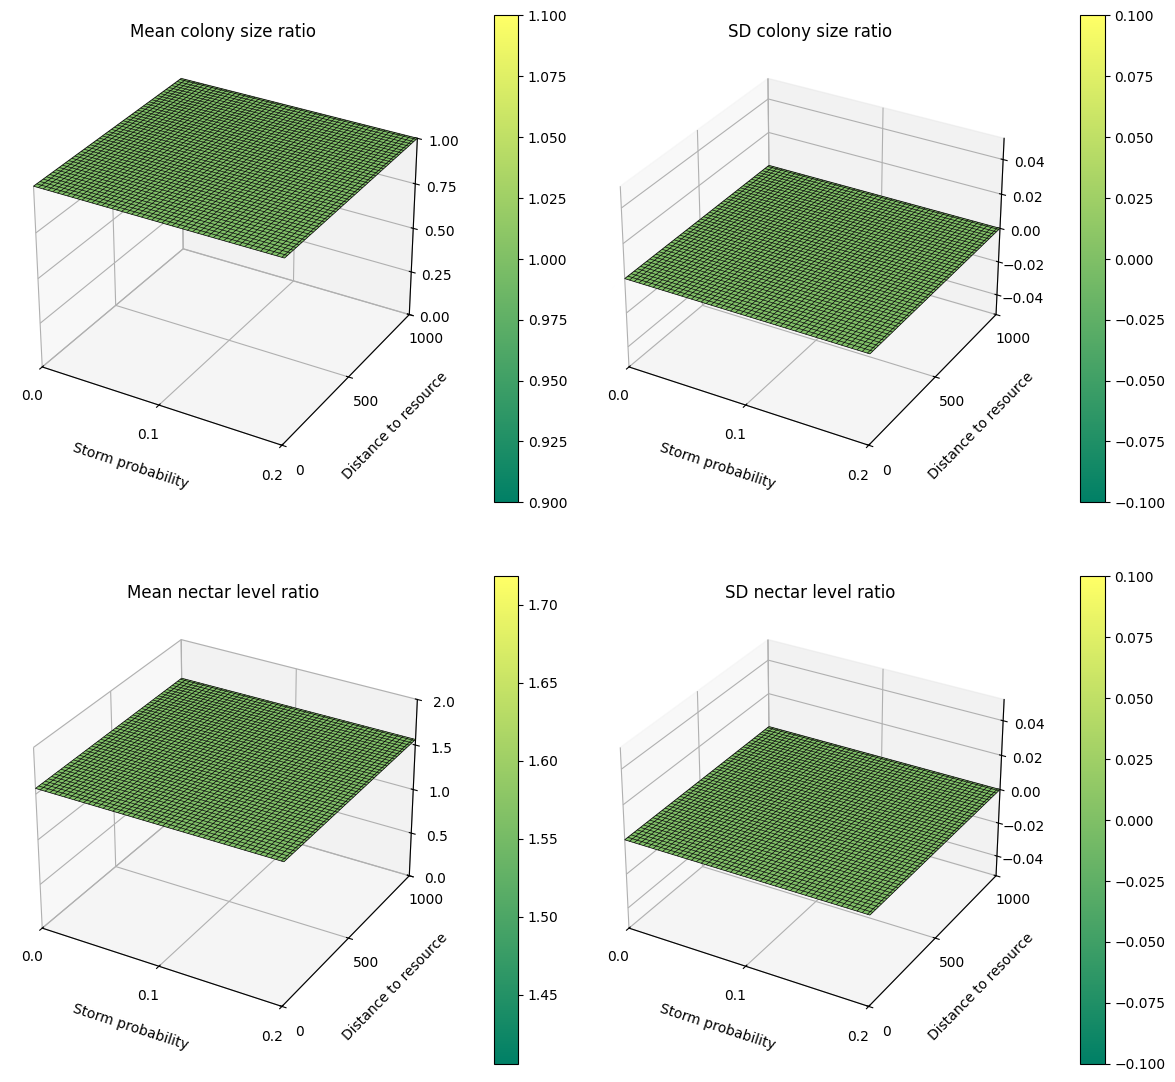

In [ ]:
X_INTERP, Y_INTERP = np.meshgrid(np.linspace(0, 0.2, 100), np.linspace(0, 1000.0, 100))

fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 12))
plot_data = [colony_mean, colony_sd, nectar_mean, nectar_sd]

for (data, ax) in zip(plot_data, axes.flatten()):
    # Smooth out data
    TCK = interpolate.bisplrep(X, Y, data, s=0)
    Z_INTERP = interpolate.bisplev(X_INTERP[:,0], Y_INTERP[0,:], TCK)

    # Plot data
    surf = ax.plot_surface(X_INTERP, Y_INTERP, Z_INTERP, cmap=plt.cm.summer, alpha=None, antialiased=True)
    ax.plot_wireframe(X_INTERP, Y_INTERP, Z_INTERP, lw=0.5, color='black', alpha=None, antialiased=True)

    # Plot settings & colorbar
    ax.set_xlabel("Storm probability", labelpad=10.0)
    ax.set_xlim(0, 0.2)
    ax.set_xticks(np.linspace(0, 0.2, 3))

    ax.set_ylabel("Distance to resource", labelpad=10.0)
    ax.set_ylim(0, 1000)
    ax.set_yticks(np.linspace(0, 1000, 3))

    fig.colorbar(surf, ax=ax, shrink=0.8, aspect=20, pad=0.1)

axes[0,0].set_title("Mean colony size ratio")
axes[0,0].set_zlim(0, 1)
axes[0,0].set_zticks(np.linspace(0, 1.0, 5))

axes[0,1].set_title("SD colony size ratio")

axes[1,0].set_title("Mean nectar level ratio")
axes[1,0].set_zlim(0, 2)
axes[1,0].set_zticks(np.linspace(0, 2.0, 5))

axes[1,1].set_title("SD nectar level ratio")

plt.tight_layout()
plt.savefig(FIGURE_PATH + "colony_survival_and_nectar_levels_smooth.png", bbox_inches='tight')